# Import

In [1]:
import pickle

# math and dataframes
import pandas as pd
import numpy as np
import scipy as sp

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import tensorflow as tf

# Pipeline and Evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.tree import plot_tree
from imblearn.pipeline import make_pipeline

# Undersampling 
# Note: undersampling was used in at least 1 paper predicting popularity (Gao 2021)
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import seaborn as sns
sns.set_theme()

In [2]:
df_10M = pd.read_pickle('df_10M_clustered.pickle')
X_all = pd.read_pickle('X_clustered.pickle')

# Create Datasets for Prediction

In [3]:
y_column = 'in_B100'
X_columns = [
    'mode', 'acousticness', 'danceability', 'duration_ms', 'energy',
    'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]
genre_columns = [
    'is_Adult_Standard', 'is_Rock', 'is_R&B', 'is_Country', 'is_Pop',
    'is_Rap', 'is_Alternative', 'is_EDM', 'is_Metal'
]
cluster_columns = ['cluster', 'cluster2']
other_columns = ['key', 'time_signature', 'genre', 'release_date']


In [4]:
# create a dict with all 'name': (X, y) key match pairs
clusters = {}

# entire predictive dataset
clusters['All'] = (X_all[X_columns+genre_columns], X_all[y_column])
# clusters['All'] = (X_all[X_columns], X_all[y_column])

# add genres
for genre in genre_columns:
    title = genre[3:]
    clusters[title] = (X_all[X_all[genre]][X_columns], X_all[X_all[genre]][y_column])
    
# add clusters
for n in sorted(X_all['cluster'].unique()):
    title = genre[3:]
    clusters['cluster1_' + str(n)] = (X_all[X_all['cluster'] == n][X_columns], X_all[X_all['cluster'] == n][y_column])
    
for n in sorted(X_all['cluster2'].unique()):
    title = genre[3:]
    clusters['cluster2_' + str(n)] = (X_all[X_all['cluster2'] == n][X_columns], X_all[X_all['cluster2'] == n][y_column])
    
# setup tuning algorithm with a small dataset
small = X_all.sample(10_000, random_state=42)
X_small = small[X_columns]
y_small = small[y_column]
clusters['small'] = (X_small, y_small)
    
# OPTIONAL IF TIME PERMITS: consider adding decades or eras of music

# Tune Algorithms

In [5]:
cluster_keys = [
    'All', 
    'Adult_Standard', 'Rock', 'R&B', 'Country', 'Pop', 'Rap', 'Alternative', 'EDM', 'Metal', 
    'cluster1_0', 'cluster1_1', 'cluster1_2', 'cluster1_3', 
    'cluster2_0', 'cluster2_1', 'cluster2_2', 'cluster2_3', 'cluster2_4', 
    'cluster2_5', 'cluster2_6', 'cluster2_7', 'cluster2_8', 'cluster2_9',
    'small'
]

In [6]:
# setup model parameters for grid search

ML_algorithms = [
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    RandomForestClassifier,
    AdaBoostClassifier
]

param_by_model = {}

params_lr = {}
orders_of_magnitude = []
for lst in [[int(x)/10000 for x in range(1, 11)],
            [int(x)/1000 for x in range(1, 11)],
            [int(x)/100 for x in range(1, 11)],
            [int(x)/10 for x in range(1, 11)],
            [1 * x for x in range(1, 11)],
            [10 * x for x in range(1, 11)],
            [100 * x for x in range(1, 11)],
            [1000 * x for x in range(1, 11)]]:
    orders_of_magnitude += lst
params_lr['logisticregression__penalty'] = ['l1', 'l2']
params_lr['logisticregression__C'] = orders_of_magnitude
params_lr['logisticregression__solver'] = ['liblinear']
param_by_model[0] = params_lr

params_dt = {}
params_dt['decisiontreeclassifier__max_depth'] = [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 100, None]
params_dt['decisiontreeclassifier__min_samples_leaf'] = [5, 10, 50, 100, 1000]
params_dt['decisiontreeclassifier__criterion'] = ['gini', 'entropy']
param_by_model[1] = params_dt

params_knn = {}
params_knn['kneighborsclassifier__n_neighbors'] = [x for x in range(2,20)]+[x for x in range(20,101,5)]
params_knn['kneighborsclassifier__weights'] = ['uniform', 'distance']
params_knn['kneighborsclassifier__metric'] = ['minkowski', 'euclidean', 'manhattan']
param_by_model[2] = params_knn

params_rf = {}
params_rf['randomforestclassifier__n_estimators'] = [5, 10, 20, 50, 100, 200, 500, 1000, 2000]
params_rf['randomforestclassifier__max_features'] = ['sqrt', 'log2']
params_rf['randomforestclassifier__max_depth'] = [3, 5, 7, 10, 15, 20, 30, 50, 100, None]
params_rf['randomforestclassifier__min_samples_leaf'] = [5, 10, 50, 100, 1000]
params_rf['randomforestclassifier__bootstrap'] = [True, False]
param_by_model[3] = params_rf

params_ab = {}
params_ab['adaboostclassifier__n_estimators'] = [10, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
params_ab['adaboostclassifier__learning_rate'] = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0]
params_ab['adaboostclassifier__algorithm'] = ['SAMME', 'SAMME.R']
param_by_model[4] = params_ab

In [29]:
# how many scenarios in the grid search

def how_many_scenarios(n_ML):
    n_scenarios = 1
    for key in param_by_model[n_ML].keys():
        n_scenarios *=  len(param_by_model[n_ML][key])
    return n_scenarios

for i in range(5):
    print(str(ML_algorithms[i]())[:-2], how_many_scenarios(i))

LogisticRegression 160
DecisionTreeClassifier 160
KNeighborsClassifier 210
RandomForestClassifier 1800
AdaBoostClassifier 162


In [49]:
def fit_predict_metric_model(n_ML, dataset='small', n_cv=5, scoring='roc_auc', undersample=True, cv_res_print=False, heatmap=False):
    
    # split the dataset into train test
    X_, y_ = clusters[dataset]
    X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42, stratify=y_)
        
    # params
    param_grid = param_by_model[n_ML]

    # pipeline
    if undersample:
        pipe = make_pipeline(
            RandomUnderSampler(sampling_strategy='majority', random_state=42), 
            ML_algorithms[n_ML]()
        )
    else:
        if n_ML in [0, 1, 3]:
            pipe = make_pipeline(ML_algorithms[n_ML](class_weight='balanced'))
        else:
            pipe = make_pipeline(ML_algorithms[n_ML]())

    # gridsearch
    cv = StratifiedKFold(n_splits=n_cv, shuffle=True)
    grid = GridSearchCV(
        estimator = pipe,
        param_grid = param_grid,
        cv = cv,
        scoring = scoring, 
        n_jobs = -1
    )

    # calculate best parameters
    grid.fit(X_train, y_train)

    # results
    cv_results = (
        grid.best_params_,
        grid.cv_results_['mean_test_score'].mean(), 
        grid.cv_results_['mean_test_score'].min(), 
        grid.cv_results_['mean_test_score'].max()
    )
    
    # print header
    if undersample:
        undersample_description = 'Undersampled'
    else:
        undersample_description = 'Full Dataset'
    print(
        '\nScenario\n------------------------------\n', str(ML_algorithms[0]())[:-2], 
        dataset.title(), 
        scoring, 
        undersample_description
    )
    
    if cv_res_print:
        # print cv results
        print('\nCrossvalidation Results\n------------------------------')
        for i in cv_results:
            print(i)

    # print predictions
    y_pred = grid.predict(X_test)
    print('\nClassification Report\n------------------------------\n', classification_report(y_test, y_pred))
    
    if heatmap:
        print('\nConfusion Matrix\n------------------------------')
        plt.subplots(figsize=(6, 6))
        sns.heatmap(confusion_matrix(y_test, y_pred), vmin=0, cmap='Blues', annot=True, fmt='.0f', cbar=False,
                   xticklabels=['Not Popular', 'Billboard Hit'], yticklabels=['Not Popular', 'Billboard Hit'])
        plt.ylabel('Predicted')
        plt.xlabel('Actual')
        plt.show()

In [41]:
# scenarios to check

metrics = [
    'balanced_accuracy', 'average_precision', 'neg_brier_score', 'f1', 'f1_micro', 
    'f1_macro', 'f1_weighted', 'neg_log_loss', 'precision', 'recall', 'roc_auc', 'jaccard'
]

cluster1_keys = [
    'cluster1_0', 'cluster1_1', 'cluster1_2', 'cluster1_3'
]

cluster2_keys = [
    'cluster2_0', 'cluster2_1', 'cluster2_2', 'cluster2_3', 'cluster2_4', 
    'cluster2_5', 'cluster2_6', 'cluster2_7', 'cluster2_8', 'cluster2_9',
]

genre_keys = [
    'Adult_Standard', 'Rock', 'R&B', 'Country', 'Pop', 'Rap', 'Alternative', 'EDM', 'Metal'
]

# LAST TRY: narrow results by year
## still no.  this looks untrainable.
maybe a neural network will have better luck...

In [71]:
X_ = X_all[(X_all['is_Rock']) & (X_all.release_date.dt.year.isin(list(range(2010, 2022))))][X_columns]
y_ = X_all[(X_all['is_Rock']) & (X_all.release_date.dt.year.isin(list(range(2010, 2022))))][y_column]

clusters['modern_rock'] = X_, y_
clusters['modern_rock'][1].sum()

1321

In [72]:
%%time
fit_predict_metric_model(0, dataset='modern_rock', n_cv=3, scoring='roc_auc', cv_res_print=False, undersample=True, heatmap=False)


Scenario
------------------------------
 LogisticRegression Modern_Rock roc_auc Undersampled

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.60      0.75     56600
        True       0.01      0.78      0.02       264

    accuracy                           0.60     56864
   macro avg       0.50      0.69      0.38     56864
weighted avg       0.99      0.60      0.75     56864

Wall time: 2min 10s


In [73]:
%%time
# check metrics
undersample = True

for metric in metrics:
    fit_predict_metric_model(0, dataset='modern_rock', n_cv=5, scoring=metric, 
                             cv_res_print=False, undersample=undersample, heatmap=False)


Scenario
------------------------------
 LogisticRegression Modern_Rock balanced_accuracy Undersampled

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.60      0.75     56600
        True       0.01      0.77      0.02       264

    accuracy                           0.60     56864
   macro avg       0.50      0.69      0.38     56864
weighted avg       0.99      0.60      0.74     56864


Scenario
------------------------------
 LogisticRegression Modern_Rock average_precision Undersampled

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.60      0.75     56600
        True       0.01      0.78      0.02       264

    accuracy                           0.60     56864
   macro avg       0.50      0.69      0.38     56864
weighted avg       0.99      0.60      0.75     56864


Scenario
------------------

C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Scenario
------------------------------
 LogisticRegression Modern_Rock f1_macro Undersampled

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     56600
        True       0.00      0.00      0.00       264

    accuracy                           1.00     56864
   macro avg       0.50      0.50      0.50     56864
weighted avg       0.99      1.00      0.99     56864



C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Scenario
------------------------------
 LogisticRegression Modern_Rock f1_weighted Undersampled

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     56600
        True       0.00      0.00      0.00       264

    accuracy                           1.00     56864
   macro avg       0.50      0.50      0.50     56864
weighted avg       0.99      1.00      0.99     56864



C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Scenario
------------------------------
 LogisticRegression Modern_Rock neg_log_loss Undersampled

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.60      0.75     56600
        True       0.01      0.78      0.02       264

    accuracy                           0.60     56864
   macro avg       0.50      0.69      0.38     56864
weighted avg       0.99      0.60      0.75     56864


Scenario
------------------------------
 LogisticRegression Modern_Rock precision Undersampled

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.60      0.75     56600
        True       0.01      0.77      0.02       264

    accuracy                           0.60     56864
   macro avg       0.50      0.69      0.38     56864
weighted avg       0.99      0.60      0.75     56864


Scenario
------------------------------


# OLD CODE: no meaningful results

##### Logistic Regression - try a bunch of metrics fully sampled

In [50]:
%%time
fit_predict_metric_model(0, dataset='small', n_cv=5, scoring=metric, cv_res_print=False, undersample=True, heatmap=False)


Scenario
------------------------------
 LogisticRegression Small roc_auc Undersampled

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.35      0.52      1994
        True       0.00      0.83      0.01         6

    accuracy                           0.35      2000
   macro avg       0.50      0.59      0.26      2000
weighted avg       1.00      0.35      0.52      2000

Wall time: 2.68 s


In [51]:
%%time
fit_predict_metric_model(0, dataset='small', n_cv=5, scoring=metric, cv_res_print=False, undersample=False, heatmap=False)


Scenario
------------------------------
 LogisticRegression Small roc_auc Full Dataset

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.59      0.74      1994
        True       0.00      0.67      0.01         6

    accuracy                           0.59      2000
   macro avg       0.50      0.63      0.38      2000
weighted avg       1.00      0.59      0.74      2000

Wall time: 18.2 s


In [52]:
%%time
# check metrics
undersample = True

for metric in metrics:
    fit_predict_metric_model(0, dataset='small', n_cv=5, scoring=metric, cv_res_print=False, undersample=undersample, heatmap=False)


Scenario
------------------------------
 LogisticRegression Small balanced_accuracy Undersampled

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.42      0.59      1994
        True       0.00      0.83      0.01         6

    accuracy                           0.42      2000
   macro avg       0.50      0.63      0.30      2000
weighted avg       1.00      0.42      0.59      2000


Scenario
------------------------------
 LogisticRegression Small average_precision Undersampled

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.42      0.60      1994
        True       0.00      0.67      0.01         6

    accuracy                           0.42      2000
   macro avg       0.50      0.55      0.30      2000
weighted avg       0.99      0.42      0.59      2000


Scenario
------------------------------

C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Scenario
------------------------------
 LogisticRegression Small f1_macro Undersampled

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      1994
        True       0.00      0.00      0.00         6

    accuracy                           1.00      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.99      1.00      1.00      2000



C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Scenario
------------------------------
 LogisticRegression Small f1_weighted Undersampled

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      1994
        True       0.00      0.00      0.00         6

    accuracy                           1.00      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.99      1.00      1.00      2000



C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Scenario
------------------------------
 LogisticRegression Small neg_log_loss Undersampled

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.44      0.61      1994
        True       0.00      0.83      0.01         6

    accuracy                           0.45      2000
   macro avg       0.50      0.64      0.31      2000
weighted avg       1.00      0.45      0.61      2000


Scenario
------------------------------
 LogisticRegression Small precision Undersampled

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.46      0.63      1994
        True       0.00      0.83      0.01         6

    accuracy                           0.46      2000
   macro avg       0.50      0.65      0.32      2000
weighted avg       1.00      0.46      0.63      2000


Scenario
------------------------------
 LogisticReg

In [54]:
%%time
# check clusters
undersample = True

for key in cluster1_keys:
    fit_predict_metric_model(0, dataset=key, n_cv=5, scoring='roc_auc', cv_res_print=False, undersample=undersample, heatmap=False)


Scenario
------------------------------
 LogisticRegression Cluster1_0 roc_auc Undersampled

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.73      0.85    246687
        True       0.00      0.68      0.00        37

    accuracy                           0.73    246724
   macro avg       0.50      0.71      0.42    246724
weighted avg       1.00      0.73      0.85    246724


Scenario
------------------------------
 LogisticRegression Cluster1_1 roc_auc Undersampled

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.55      0.71    792706
        True       0.01      0.67      0.01      2932

    accuracy                           0.55    795638
   macro avg       0.50      0.61      0.36    795638
weighted avg       0.99      0.55      0.71    795638


Scenario
------------------------------
 Logistic

# OLDER CODE: no meaningful results

### Logistic Regression

#### huge loop (all night not nearly enough, better now anyway)


Crossvalidation Results
------------------------------
{'logisticregression__C': 0.009, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.8042941132562011
0.5
0.8256946174731997

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.81      0.89   1761298
        True       0.01      0.84      0.02      4246

    accuracy                           0.81   1765544
   macro avg       0.50      0.83      0.46   1765544
weighted avg       1.00      0.81      0.89   1765544


Confusion Matrix
------------------------------


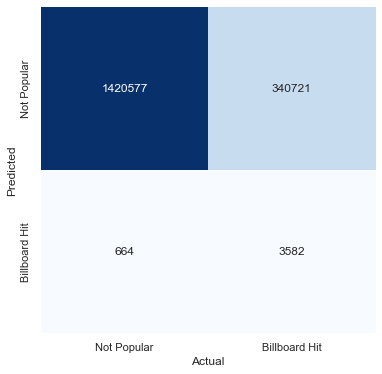


Crossvalidation Results
------------------------------
{'logisticregression__C': 8, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.6869142495557456
0.5
0.7195639245553602

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       0.99      0.69      0.81     41036
        True       0.04      0.74      0.08       736

    accuracy                           0.69     41772
   macro avg       0.52      0.71      0.44     41772
weighted avg       0.98      0.69      0.80     41772


Confusion Matrix
------------------------------


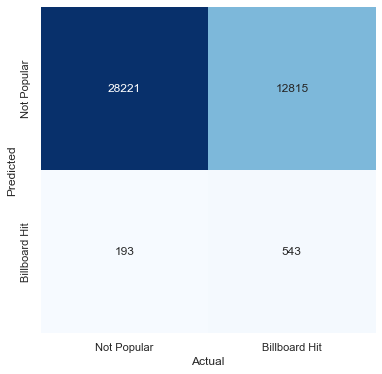


Crossvalidation Results
------------------------------
{'logisticregression__C': 5000, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.6332849131218476
0.5
0.6582952381472722

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.56      0.72    130174
        True       0.02      0.76      0.03      1262

    accuracy                           0.56    131436
   macro avg       0.51      0.66      0.37    131436
weighted avg       0.99      0.56      0.71    131436


Confusion Matrix
------------------------------


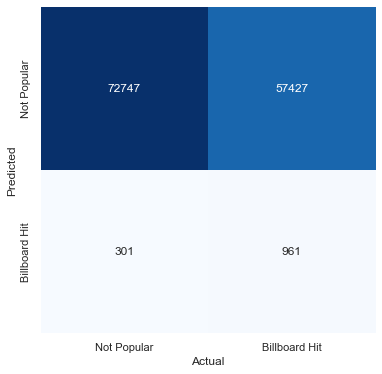


Crossvalidation Results
------------------------------
{'logisticregression__C': 8, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.6344145961763789
0.5
0.6656131612510923

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       0.99      0.58      0.73     26723
        True       0.04      0.72      0.07       593

    accuracy                           0.58     27316
   macro avg       0.51      0.65      0.40     27316
weighted avg       0.97      0.58      0.72     27316


Confusion Matrix
------------------------------


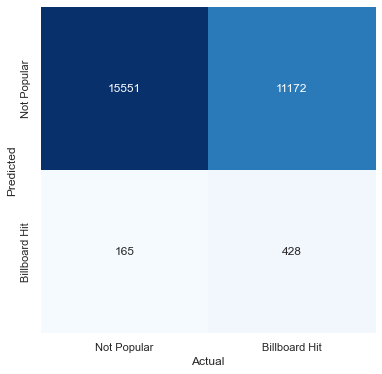


Crossvalidation Results
------------------------------
{'logisticregression__C': 200, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.6732711489948734
0.5
0.7081113204966838

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.65      0.79     53554
        True       0.02      0.75      0.04       490

    accuracy                           0.65     54044
   macro avg       0.51      0.70      0.41     54044
weighted avg       0.99      0.65      0.78     54044


Confusion Matrix
------------------------------


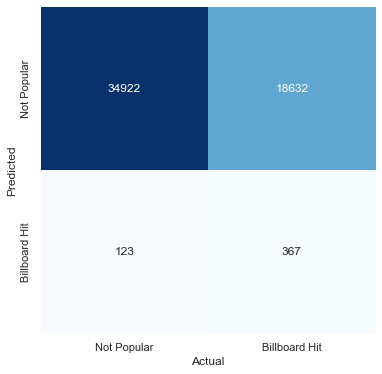


Crossvalidation Results
------------------------------
{'logisticregression__C': 1000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.5882125451648317
0.5
0.6128748950789421

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.53      0.69    107245
        True       0.01      0.68      0.02       781

    accuracy                           0.53    108026
   macro avg       0.50      0.60      0.36    108026
weighted avg       0.99      0.53      0.69    108026


Confusion Matrix
------------------------------


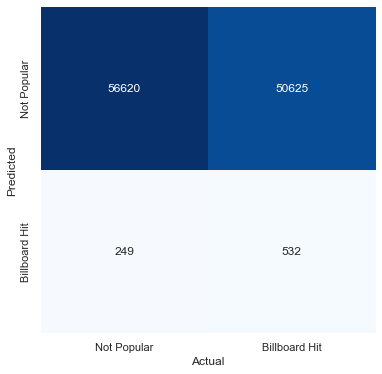


Crossvalidation Results
------------------------------
{'logisticregression__C': 60, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.6120798508260249
0.5
0.6425631897369131

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.60      0.75     82783
        True       0.01      0.67      0.02       417

    accuracy                           0.60     83200
   macro avg       0.50      0.64      0.38     83200
weighted avg       0.99      0.60      0.75     83200


Confusion Matrix
------------------------------


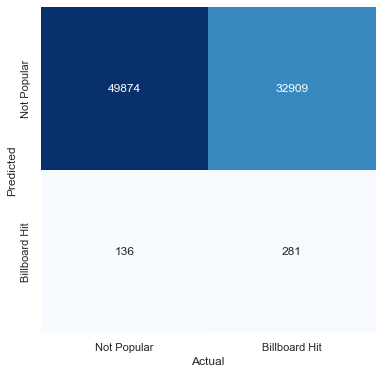


Crossvalidation Results
------------------------------
{'logisticregression__C': 30, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.6706258146543931
0.5
0.7679482868769641

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.66      0.79     16955
        True       0.00      0.74      0.01        35

    accuracy                           0.66     16990
   macro avg       0.50      0.70      0.40     16990
weighted avg       1.00      0.66      0.79     16990


Confusion Matrix
------------------------------


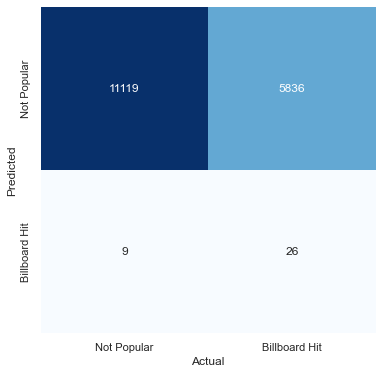


Crossvalidation Results
------------------------------
{'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.722902892834092
0.5
0.8021784554900144

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.79      0.88     49899
        True       0.00      0.81      0.00        21

    accuracy                           0.79     49920
   macro avg       0.50      0.80      0.44     49920
weighted avg       1.00      0.79      0.88     49920


Confusion Matrix
------------------------------


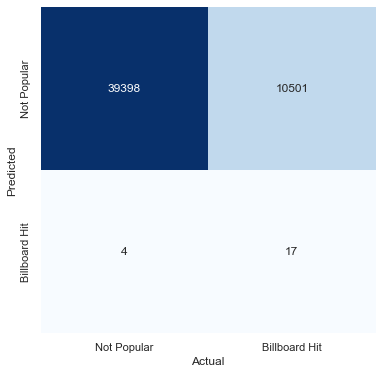


Crossvalidation Results
------------------------------
{'logisticregression__C': 60, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.732280182879476
0.5
0.8305673625421826

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.75      0.86     49052
        True       0.00      0.89      0.00        28

    accuracy                           0.75     49080
   macro avg       0.50      0.82      0.43     49080
weighted avg       1.00      0.75      0.86     49080


Confusion Matrix
------------------------------


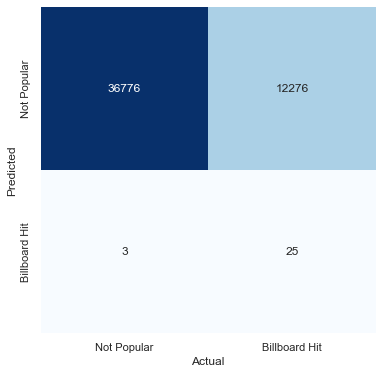


Crossvalidation Results
------------------------------
{'logisticregression__C': 600, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.6744381091702845
0.5
0.7580791502331137

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.71      0.83    246687
        True       0.00      0.73      0.00        37

    accuracy                           0.71    246724
   macro avg       0.50      0.72      0.42    246724
weighted avg       1.00      0.71      0.83    246724


Confusion Matrix
------------------------------


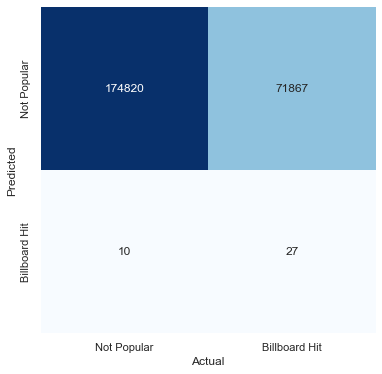


Crossvalidation Results
------------------------------
{'logisticregression__C': 100, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.5948515113154983
0.5
0.6118862252459661

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.56      0.71    792706
        True       0.01      0.66      0.01      2932

    accuracy                           0.56    795638
   macro avg       0.50      0.61      0.36    795638
weighted avg       0.99      0.56      0.71    795638


Confusion Matrix
------------------------------


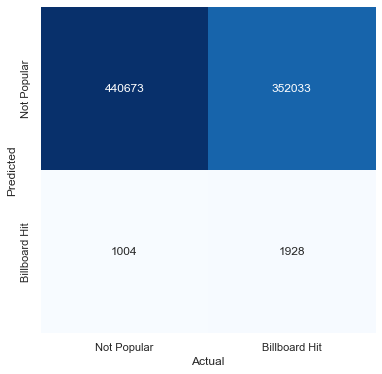


Crossvalidation Results
------------------------------
{'logisticregression__C': 90, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.6540706619628344
0.5
0.684853996587149

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.65      0.79    459788
        True       0.00      0.69      0.01      1169

    accuracy                           0.65    460957
   macro avg       0.50      0.67      0.40    460957
weighted avg       1.00      0.65      0.79    460957


Confusion Matrix
------------------------------


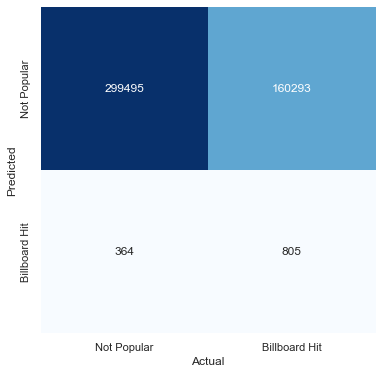


Crossvalidation Results
------------------------------
{'logisticregression__C': 700, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.694182399777454
0.5
0.7538217092276721

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.72      0.84    262118
        True       0.00      0.81      0.00       108

    accuracy                           0.72    262226
   macro avg       0.50      0.76      0.42    262226
weighted avg       1.00      0.72      0.84    262226


Confusion Matrix
------------------------------


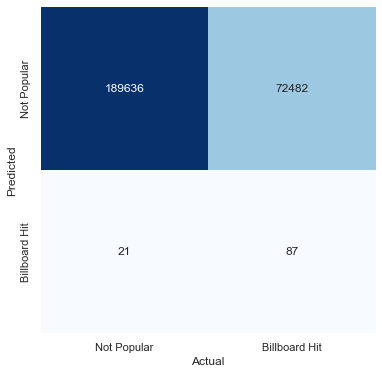


Crossvalidation Results
------------------------------
{'logisticregression__C': 30, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.6274434784895853
0.5
0.6735212829484863

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.61      0.76    198682
        True       0.00      0.74      0.01       431

    accuracy                           0.61    199113
   macro avg       0.50      0.68      0.38    199113
weighted avg       1.00      0.61      0.76    199113


Confusion Matrix
------------------------------


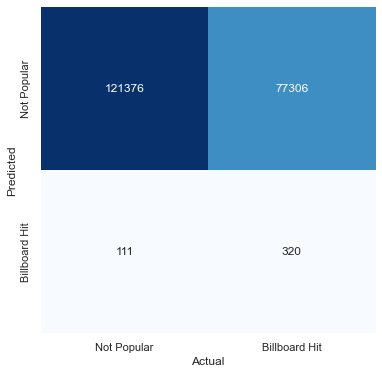


Crossvalidation Results
------------------------------
{'logisticregression__C': 30, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.6447099539994108
0.5
0.6857795274065772

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.62      0.77    216707
        True       0.01      0.77      0.01       689

    accuracy                           0.62    217396
   macro avg       0.50      0.70      0.39    217396
weighted avg       1.00      0.62      0.76    217396


Confusion Matrix
------------------------------


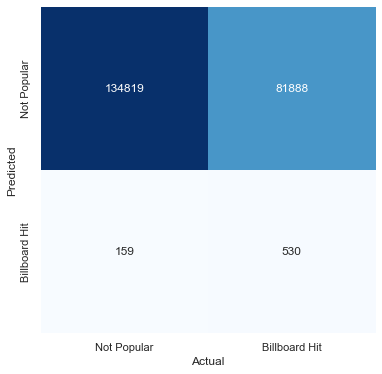


Crossvalidation Results
------------------------------
{'logisticregression__C': 5, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.6513432056435722
0.5
0.7773473990394028

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.67      0.80    163874
        True       0.00      0.82      0.00        11

    accuracy                           0.67    163885
   macro avg       0.50      0.75      0.40    163885
weighted avg       1.00      0.67      0.80    163885


Confusion Matrix
------------------------------


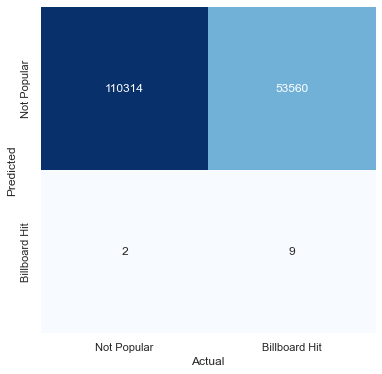


Crossvalidation Results
------------------------------
{'logisticregression__C': 3, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.6296189659316349
0.4957010658634073
0.714039966475319

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.69      0.82    151053
        True       0.00      0.85      0.00        20

    accuracy                           0.69    151073
   macro avg       0.50      0.77      0.41    151073
weighted avg       1.00      0.69      0.82    151073


Confusion Matrix
------------------------------


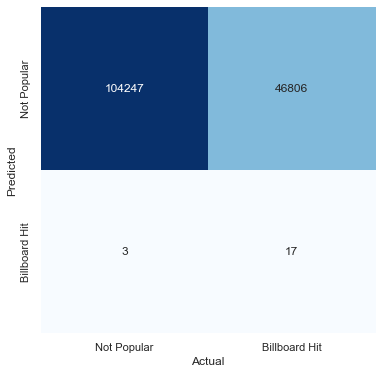


Crossvalidation Results
------------------------------
{'logisticregression__C': 1000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.6117142775609496
0.492768158131177
0.692012886205871

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.62      0.77     82813
        True       0.00      0.77      0.00        26

    accuracy                           0.62     82839
   macro avg       0.50      0.70      0.38     82839
weighted avg       1.00      0.62      0.77     82839


Confusion Matrix
------------------------------


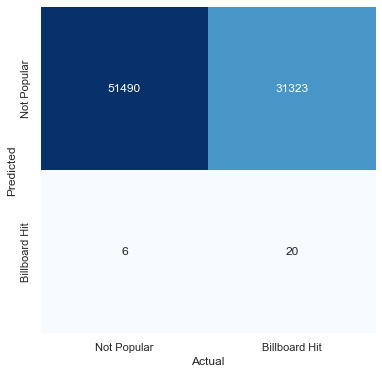


Crossvalidation Results
------------------------------
{'logisticregression__C': 7000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.5714956117966811
0.5
0.5983111921622664

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.50      0.67    186073
        True       0.01      0.69      0.01       754

    accuracy                           0.50    186827
   macro avg       0.50      0.59      0.34    186827
weighted avg       0.99      0.50      0.66    186827


Confusion Matrix
------------------------------


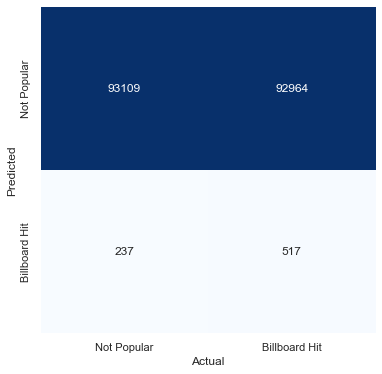


Crossvalidation Results
------------------------------
{'logisticregression__C': 500, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.6100938972144093
0.5
0.6527650912904995

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.61      0.75     63399
        True       0.00      0.70      0.01       177

    accuracy                           0.61     63576
   macro avg       0.50      0.65      0.38     63576
weighted avg       1.00      0.61      0.75     63576


Confusion Matrix
------------------------------


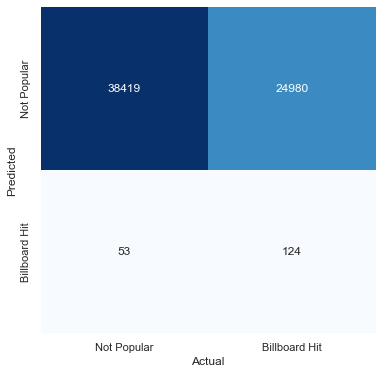


Crossvalidation Results
------------------------------
{'logisticregression__C': 1000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.590342107902711
0.5
0.6172433188635492

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.59      0.74    344555
        True       0.01      0.64      0.01      1570

    accuracy                           0.59    346125
   macro avg       0.50      0.61      0.38    346125
weighted avg       0.99      0.59      0.74    346125


Confusion Matrix
------------------------------


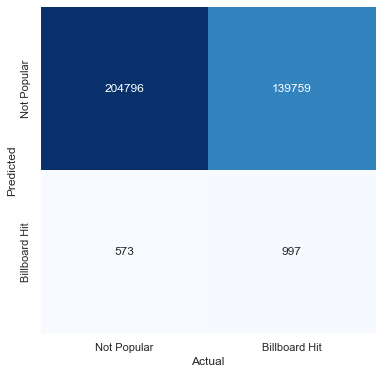


Crossvalidation Results
------------------------------
{'logisticregression__C': 1000, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.6548671887445409
0.5
0.6955580043259768

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.66      0.79    243081
        True       0.00      0.71      0.01       480

    accuracy                           0.66    243561
   macro avg       0.50      0.68      0.40    243561
weighted avg       1.00      0.66      0.79    243561


Confusion Matrix
------------------------------


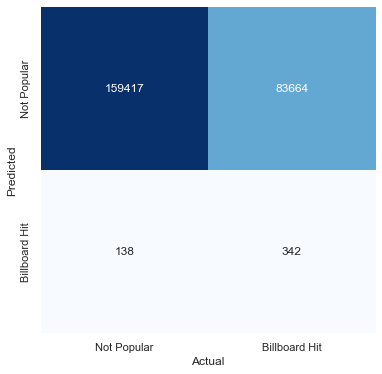


Crossvalidation Results
------------------------------
{'logisticregression__C': 600, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.6290728464099106
0.5
0.6924158077838067

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.66      0.79    111066
        True       0.00      0.75      0.00        88

    accuracy                           0.66    111154
   macro avg       0.50      0.70      0.40    111154
weighted avg       1.00      0.66      0.79    111154


Confusion Matrix
------------------------------


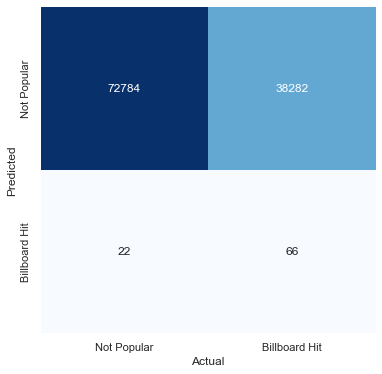


Crossvalidation Results
------------------------------
{'logisticregression__C': 8000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.5686503086674366
0.5
0.6806664388243335

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.53      0.70      1994
        True       0.01      0.83      0.01         6

    accuracy                           0.53      2000
   macro avg       0.50      0.68      0.35      2000
weighted avg       1.00      0.53      0.69      2000


Confusion Matrix
------------------------------


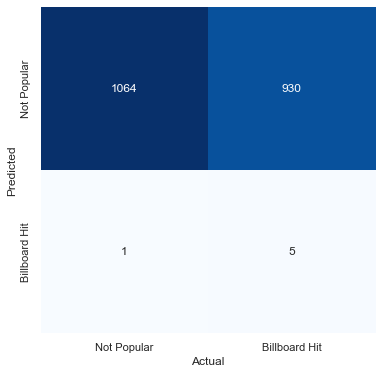

Wall time: 6h 59min 24s


In [136]:
%%time
for key in cluster_keys:
    fit_predict_metric_model(0, dataset=key, n_cv=5, scoring='balanced_accuracy')


Crossvalidation Results
------------------------------
{'logisticregression__C': 0.09, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.01829473694962618
0.0024047832289627487
0.01993101443370367

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.81      0.90   1761298
        True       0.01      0.84      0.02      4246

    accuracy                           0.81   1765544
   macro avg       0.51      0.82      0.46   1765544
weighted avg       1.00      0.81      0.89   1765544


Confusion Matrix
------------------------------


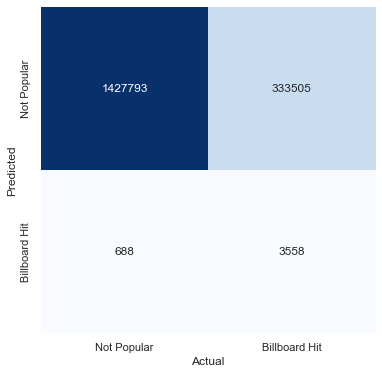


Crossvalidation Results
------------------------------
{'logisticregression__C': 1000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.04148734467984369
0.017607488130162854
0.045770557750466415

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       0.99      0.69      0.81     41036
        True       0.04      0.73      0.08       736

    accuracy                           0.69     41772
   macro avg       0.52      0.71      0.45     41772
weighted avg       0.98      0.69      0.80     41772


Confusion Matrix
------------------------------


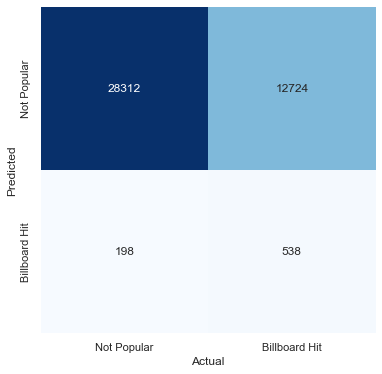


Crossvalidation Results
------------------------------
{'logisticregression__C': 40, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.018421782695288307
0.009603588075061675
0.020537289997131655

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.55      0.71    130174
        True       0.02      0.77      0.03      1262

    accuracy                           0.55    131436
   macro avg       0.51      0.66      0.37    131436
weighted avg       0.99      0.55      0.70    131436


Confusion Matrix
------------------------------


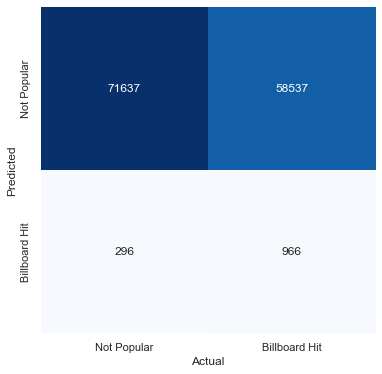


Crossvalidation Results
------------------------------
{'logisticregression__C': 700, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.042421253381474455
0.021709285444882535
0.04820237783816224

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       0.99      0.57      0.72     26723
        True       0.04      0.73      0.07       593

    accuracy                           0.57     27316
   macro avg       0.51      0.65      0.40     27316
weighted avg       0.97      0.57      0.71     27316


Confusion Matrix
------------------------------


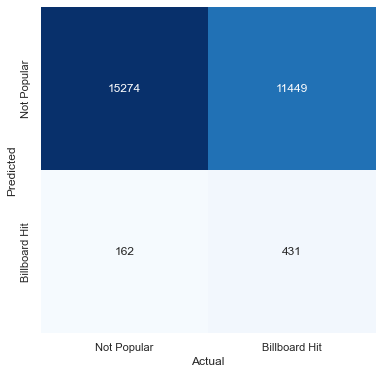


Crossvalidation Results
------------------------------
{'logisticregression__C': 400, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.023594244228084166
0.00905760219523204
0.027038646384219288

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.65      0.79     53554
        True       0.02      0.75      0.04       490

    accuracy                           0.65     54044
   macro avg       0.51      0.70      0.41     54044
weighted avg       0.99      0.65      0.78     54044


Confusion Matrix
------------------------------


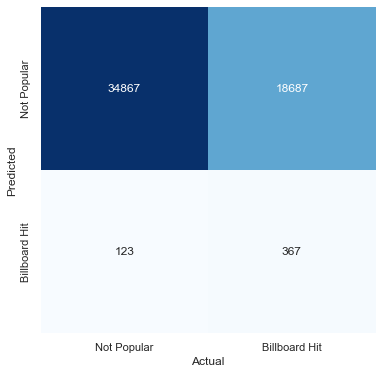


Crossvalidation Results
------------------------------
{'logisticregression__C': 9, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.010207719684981418
0.00722749363573247
0.010991391466346851

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.53      0.69    107245
        True       0.01      0.69      0.02       781

    accuracy                           0.53    108026
   macro avg       0.50      0.61      0.36    108026
weighted avg       0.99      0.53      0.69    108026


Confusion Matrix
------------------------------


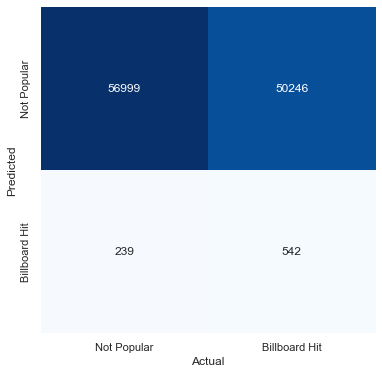

KeyboardInterrupt: 

In [137]:
%%time
for key in cluster_keys:
    fit_predict_metric_model(0, dataset=key, n_cv=5, scoring='average_precision')

#### tons of scenarios


Crossvalidation Results
------------------------------
{'logisticregression__C': 10000, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.7444842972791343
0.5
0.7761325331485998

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       0.99      0.68      0.81     41036
        True       0.04      0.75      0.08       736

    accuracy                           0.69     41772
   macro avg       0.52      0.72      0.44     41772
weighted avg       0.98      0.69      0.80     41772


Confusion Matrix
------------------------------


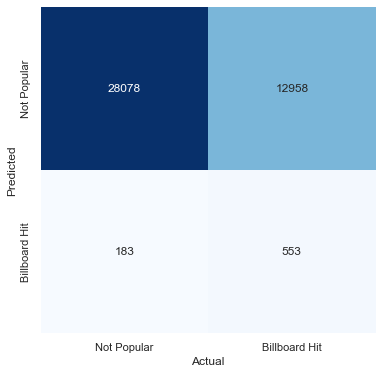

Wall time: 2min 19s


In [117]:
%%time
fit_predict_metric_model(0, dataset='Adult_Standard', n_cv=5, scoring='roc_auc')


Crossvalidation Results
------------------------------
{'logisticregression__C': 1000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.036047234406268155
0.0
0.04133573588086714

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       0.99      0.69      0.81     41036
        True       0.04      0.73      0.08       736

    accuracy                           0.69     41772
   macro avg       0.52      0.71      0.45     41772
weighted avg       0.98      0.69      0.80     41772


Confusion Matrix
------------------------------


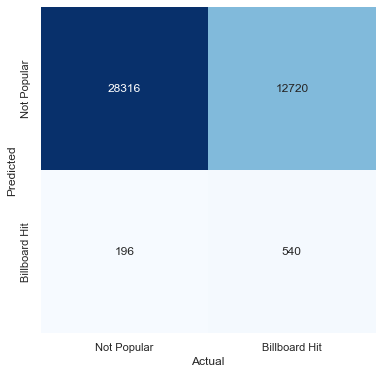

Wall time: 2min 17s


In [118]:
%%time
fit_predict_metric_model(0, dataset='Adult_Standard', n_cv=5, scoring='precision')


Crossvalidation Results
------------------------------
{'logisticregression__C': 7, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.6865216124535468
0.5
0.719398812659714

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       0.99      0.69      0.81     41036
        True       0.04      0.73      0.08       736

    accuracy                           0.69     41772
   macro avg       0.52      0.71      0.45     41772
weighted avg       0.98      0.69      0.80     41772


Confusion Matrix
------------------------------


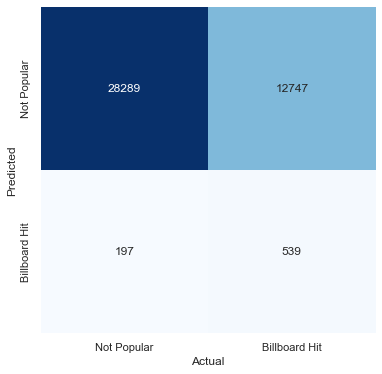

Wall time: 2min 15s


In [119]:
%%time
fit_predict_metric_model(0, dataset='Adult_Standard', n_cv=5, scoring='balanced_accuracy')


Crossvalidation Results
------------------------------
{'logisticregression__C': 5, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.06829758835589875
0.0
0.07813533772374906

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       0.99      0.69      0.81     41036
        True       0.04      0.72      0.08       736

    accuracy                           0.69     41772
   macro avg       0.52      0.71      0.44     41772
weighted avg       0.98      0.69      0.80     41772


Confusion Matrix
------------------------------


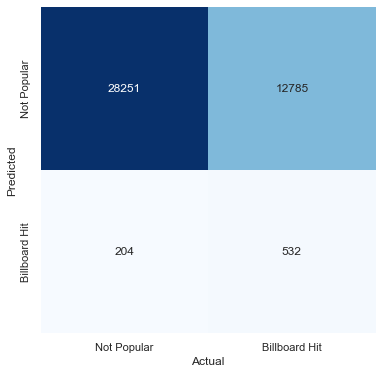

Wall time: 2min 14s


In [120]:
%%time
fit_predict_metric_model(0, dataset='Adult_Standard', n_cv=5, scoring='f1')


Crossvalidation Results
------------------------------
{'logisticregression__C': 6000, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.74835640627452
0.5
0.8187039747965861

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.73      0.84    246687
        True       0.00      0.73      0.00        37

    accuracy                           0.73    246724
   macro avg       0.50      0.73      0.42    246724
weighted avg       1.00      0.73      0.84    246724


Confusion Matrix
------------------------------


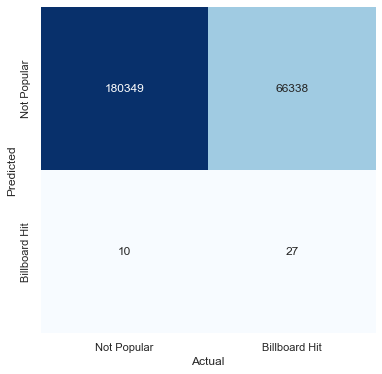

Wall time: 16min 48s


In [121]:
%%time
fit_predict_metric_model(0, dataset='cluster1_0', n_cv=5, scoring='roc_auc')


Crossvalidation Results
------------------------------
{'logisticregression__C': 4000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.632766477382648
0.5
0.6545887168003114

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.55      0.71    792706
        True       0.01      0.67      0.01      2932

    accuracy                           0.55    795638
   macro avg       0.50      0.61      0.36    795638
weighted avg       0.99      0.55      0.71    795638


Confusion Matrix
------------------------------


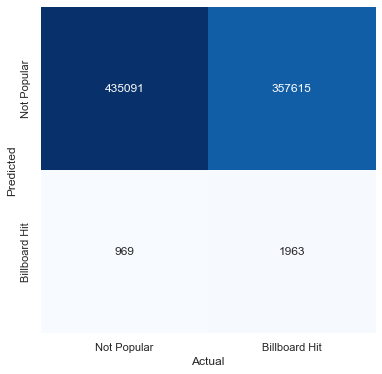

Wall time: 1h 1min 11s


In [122]:
%%time
fit_predict_metric_model(0, dataset='cluster1_1', n_cv=5, scoring='roc_auc')


Crossvalidation Results
------------------------------
{'logisticregression__C': 10000, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.7060791808054896
0.5
0.7409393784761877

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.65      0.79    459788
        True       0.01      0.70      0.01      1169

    accuracy                           0.65    460957
   macro avg       0.50      0.67      0.40    460957
weighted avg       1.00      0.65      0.79    460957


Confusion Matrix
------------------------------


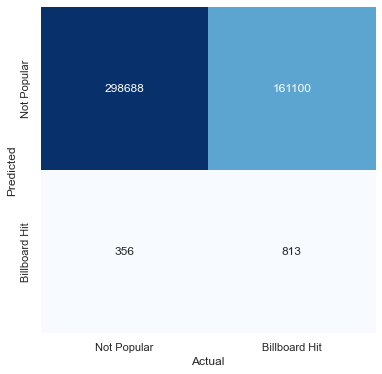

Wall time: 33min 18s


In [123]:
%%time
fit_predict_metric_model(0, dataset='cluster1_2', n_cv=5, scoring='roc_auc')


Crossvalidation Results
------------------------------
{'logisticregression__C': 60, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.766248929257866
0.5
0.8201797227720171

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.72      0.84    262118
        True       0.00      0.78      0.00       108

    accuracy                           0.72    262226
   macro avg       0.50      0.75      0.42    262226
weighted avg       1.00      0.72      0.84    262226


Confusion Matrix
------------------------------


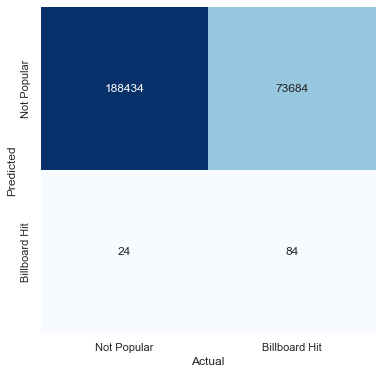

Wall time: 17min 39s


In [124]:
%%time
fit_predict_metric_model(0, dataset='cluster1_3', n_cv=5, scoring='roc_auc')

##### Other Models


Crossvalidation Results
------------------------------
{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 9, 'decisiontreeclassifier__min_samples_leaf': 100}
0.7421589523074503
0.6948494134559638
0.775807957624241

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       0.99      0.67      0.80     41036
        True       0.04      0.73      0.07       736

    accuracy                           0.67     41772
   macro avg       0.52      0.70      0.44     41772
weighted avg       0.98      0.67      0.79     41772


Confusion Matrix
------------------------------


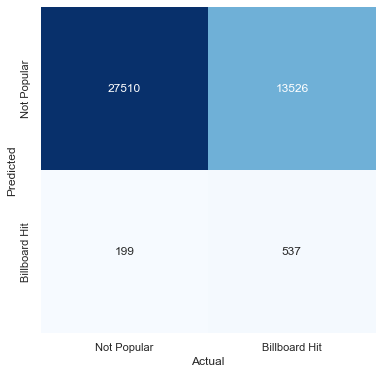

Wall time: 2min 12s


In [125]:
%%time
fit_predict_metric_model(1, dataset='Adult_Standard', n_cv=5, scoring='roc_auc')


Crossvalidation Results
------------------------------
{'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 40, 'kneighborsclassifier__weights': 'distance'}
0.7602951714362535
0.6839425877929104
0.7789305016120425

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.56      0.71     41036
        True       0.03      0.87      0.07       736

    accuracy                           0.56     41772
   macro avg       0.51      0.71      0.39     41772
weighted avg       0.98      0.56      0.70     41772


Confusion Matrix
------------------------------


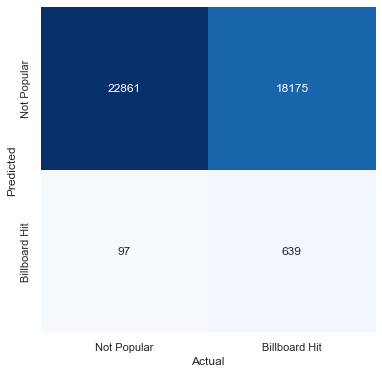

Wall time: 6min 34s


In [126]:
%%time
fit_predict_metric_model(2, dataset='Adult_Standard', n_cv=5, scoring='roc_auc')


Crossvalidation Results
------------------------------
{'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 50, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__n_estimators': 500}
0.7862043279548806
0.69201545563241
0.8101129095900592

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.66      0.80     41036
        True       0.04      0.82      0.08       736

    accuracy                           0.67     41772
   macro avg       0.52      0.74      0.44     41772
weighted avg       0.98      0.67      0.78     41772


Confusion Matrix
------------------------------


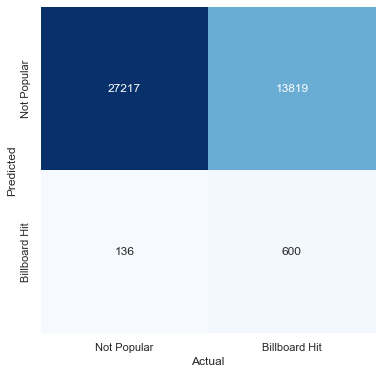

Wall time: 1h 39min 47s


In [127]:
%%time
fit_predict_metric_model(3, dataset='Adult_Standard', n_cv=5, scoring='roc_auc')


Crossvalidation Results
------------------------------
{'adaboostclassifier__algorithm': 'SAMME.R', 'adaboostclassifier__learning_rate': 0.05, 'adaboostclassifier__n_estimators': 1000}
0.7273069539528305
0.4001997699586147
0.7970740685826228

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       0.99      0.66      0.80     41036
        True       0.04      0.80      0.08       736

    accuracy                           0.67     41772
   macro avg       0.52      0.73      0.44     41772
weighted avg       0.98      0.67      0.78     41772


Confusion Matrix
------------------------------


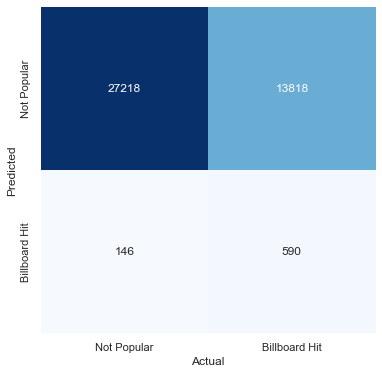

Wall time: 44min 19s


In [135]:
%%time
fit_predict_metric_model(4, dataset='Adult_Standard', n_cv=5, scoring='roc_auc')

# EVEN OLDER CODE: no meaningful results

### Which ML models did well with default settings?

In [419]:
with open('default_results.pickle', 'rb') as f:
    default_results = pickle.load(f)

In [422]:
ML_algorithms = [
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    RandomForestClassifier,
    AdaBoostClassifier
]

def default_results_by_metric(class_type='True', metric='f1-score'):
    """convert default results into readable form"""
    output_ = []

    for algo in ML_algorithms:
        algo_ = str(algo())[:-2]
        temp_ = [algo_]
        for cluster in cluster_keys:
            if class_type == 'accuracy':
                metric_ = default_results[algo_][cluster][1][class_type]
            else:
                metric_ = default_results[algo_][cluster][1][class_type][metric]
            temp_.append(metric_)
        output_.append(temp_)

    df_default_results = pd.DataFrame(output_, columns=['Model']+list(default_results['LogisticRegression'].keys()))
    df_default_results['min'] = df_default_results.iloc[:, 1:].min(axis=1)
    df_default_results['max'] = df_default_results.iloc[:, 1:].max(axis=1)
    df_default_results['mean'] = df_default_results.iloc[:, 1:].mean(axis=1)

    return df_default_results
    

In [466]:
# best performing classification by cluster = Adult_Standard (1st or 2nd for all ML models)
sortbyfeature = 'LogisticRegression'
pd.DataFrame(default_results_by_metric().iloc[:, :-3].set_index('Model').T).sort_values(sortbyfeature, ascending=False)

Model,LogisticRegression,DecisionTreeClassifier,KNeighborsClassifier,RandomForestClassifier,AdaBoostClassifier
Adult_Standard,0.077,0.060,0.065,0.080,0.077
R&B,0.072,0.063,0.065,0.081,0.076
Country,0.038,0.030,0.033,0.042,0.038
Rock,0.032,0.029,0.030,0.039,0.036
Pop,0.021,0.019,0.019,0.026,0.022
Rap,0.017,0.013,0.014,0.018,0.017
cluster2_7,0.014,0.012,0.013,0.017,0.015
cluster2_1,0.012,0.011,0.011,0.016,0.014
cluster2_5,0.011,0.010,0.010,0.014,0.012
cluster1_1,0.011,0.010,0.011,0.014,0.012


In [74]:
# adult standard is just better because of randomness... there are more to start with ...
for cluster in clusters:
    print(cluster, clusters[cluster][1].sum(), clusters[cluster][1].count(), clusters[cluster][1].sum() / clusters[cluster][1].count())

All 21229 8827719 0.0024048114807460456
Adult_Standard 3678 208860 0.01760988221775352
Rock 6311 657177 0.009603196703475625
R&B 2965 136578 0.02170920646077699
Country 2448 270216 0.009059419131361577
Pop 3904 540126 0.00722794310957073
Rap 2084 415998 0.005009639469420526
Alternative 177 84950 0.002083578575632725
EDM 103 249597 0.0004126652163287219
Metal 142 245399 0.0005786494647492451
cluster1_0 184 1233618 0.00014915476265748393
cluster1_1 14659 3978190 0.0036848415988175527
cluster1_2 5844 2304781 0.002535598826960132
cluster1_3 542 1311130 0.00041338387497807233
cluster2_0 2156 995561 0.0021656131568030487
cluster2_1 3443 1086979 0.003167494496213818
cluster2_2 56 819425 6.834060469231473e-05
cluster2_3 101 755361 0.00013371090114528021
cluster2_4 128 414193 0.00030903467707083415
cluster2_5 3772 934132 0.004037973220058835
cluster2_6 883 317876 0.0027778127320087077
cluster2_7 7848 1730621 0.0045347883794314295
cluster2_8 2401 1217802 0.0019715848717607623
cluster2_9 441 5557

### Logistic Regression

In [542]:
# huge list of orders of magnitude for gridsearch
# formatted a bit funny to avoid rounding errors
orders_of_magnitude = []
for lst in [[int(x)/10000 for x in range(1, 11)],
            [int(x)/1000 for x in range(1, 11)],
            [int(x)/100 for x in range(1, 11)],
            [int(x)/10 for x in range(1, 11)],
            [1 * x for x in range(1, 11)],
            [10 * x for x in range(1, 11)],
            [100 * x for x in range(1, 11)],
            [1000 * x for x in range(1, 11)]]:
    orders_of_magnitude += lst

In [544]:
%%time
# LOGISTIC REGRESSION

# choose dataset
am_testing = False  # test tuning setup with small dataset
if am_testing:
    X_, y_ = X_small, y_small
else:
    X_, y_ = clusters['Adult_Standard']  # has the best classification results from STEP 5

# params
scoring = 'f1'
param_grid = {}
param_grid['logisticregression__penalty'] = ['l1', 'l2']
param_grid['logisticregression__C'] = orders_of_magnitude

# pipeline
pipe = make_pipeline(
    RandomUnderSampler(sampling_strategy='majority'), 
    LogisticRegression(solver='liblinear')
)

# gridsearch
cv = StratifiedKFold(n_splits=10, shuffle=True)
lr_grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = cv,
    scoring = scoring, 
    n_jobs = -1
)

# calculate best parameters
lr_grid.fit(X_, y_)

# results
lr_grid.best_params_, lr_grid.best_score_

Wall time: 5min 3s


({'logisticregression__C': 400, 'logisticregression__penalty': 'l2'},
 0.07800708796711779)

In [553]:
# doesn't seem like tuning is doing anything
(
    lr_grid.cv_results_['mean_test_score'].mean(), 
    lr_grid.cv_results_['mean_test_score'].min(), 
    lr_grid.cv_results_['mean_test_score'].max()
)

(0.06897831928043999, 0.0, 0.07800708796711779)

In [561]:
%%time
# DECISION TREE

# choose dataset
am_testing = False  # test tuning setup with small dataset
if am_testing:
    X_, y_ = X_small, y_small
else:
    X_, y_ = clusters['Adult_Standard']  # has the best classification results from STEP 5

# params
scoring = 'f1'
param_grid = {}
param_grid['decisiontreeclassifier__max_depth'] = [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 100, None]
param_grid['decisiontreeclassifier__min_samples_leaf'] = [5, 10, 50, 100, 1000]
param_grid['decisiontreeclassifier__criterion'] = ['gini', 'entropy']

# pipeline
pipe = make_pipeline(
    RandomUnderSampler(sampling_strategy='majority'), 
    DecisionTreeClassifier()
)

# gridsearch
cv = StratifiedKFold(n_splits=10, shuffle=True)
dt_grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = cv,
    scoring = scoring, 
    n_jobs = -1
)

# calculate best parameters
dt_grid.fit(X_, y_)

# results
dt_grid.best_params_, dt_grid.best_score_

Wall time: 5min 4s


({'decisiontreeclassifier__criterion': 'gini',
  'decisiontreeclassifier__max_depth': None,
  'decisiontreeclassifier__min_samples_leaf': 50},
 0.07456561474305215)

In [562]:
# tuning isn't useful here either...
(
    dt_grid.cv_results_['mean_test_score'].mean(), 
    dt_grid.cv_results_['mean_test_score'].min(), 
    dt_grid.cv_results_['mean_test_score'].max()
)

(0.06785197229329681, 0.05958234706712688, 0.07456561474305215)

In [558]:
%%time
# KNN

# choose dataset
am_testing = False  # test tuning setup with small dataset
if am_testing:
    X_, y_ = X_small, y_small
else:
    X_, y_ = clusters['Adult_Standard']  # has the best classification results from STEP 5

# params
scoring = 'f1'
param_grid = {}
param_grid['kneighborsclassifier__n_neighbors'] = [x for x in range(2,20)]+[x for x in range(20,101,5)]
param_grid['kneighborsclassifier__weights'] = ['uniform', 'distance']
param_grid['kneighborsclassifier__metric'] = ['minkowski', 'euclidean', 'manhattan']

# pipeline
pipe = make_pipeline(
    RandomUnderSampler(sampling_strategy='majority'), 
    KNeighborsClassifier()
)

# gridsearch
cv = StratifiedKFold(n_splits=10, shuffle=True)
knn_grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = cv,
    scoring = scoring, 
    n_jobs = -1
)

# calculate best parameters
knn_grid.fit(X_, y_)

# results
knn_grid.best_params_, knn_grid.best_score_

Wall time: 13min 6s


({'kneighborsclassifier__metric': 'manhattan',
  'kneighborsclassifier__n_neighbors': 6,
  'kneighborsclassifier__weights': 'uniform'},
 0.07027638389807941)

In [559]:
# check min mean and max
(
    knn_grid.cv_results_['mean_test_score'].mean(), 
    knn_grid.cv_results_['mean_test_score'].min(), 
    knn_grid.cv_results_['mean_test_score'].max()
)

(0.06621236939350202, 0.05683753654031316, 0.07027638389807941)

In [563]:
%%time
# random forest

# choose dataset
am_testing = False  # test tuning setup with small dataset
if am_testing:
    X_, y_ = X_small, y_small
else:
    X_, y_ = clusters['Adult_Standard']  # has the best classification results from STEP 5

# params
scoring = 'f1'
param_grid = {}
param_grid['randomforestclassifier__n_estimators'] = [5, 10, 20, 50, 100, 200, 500, 1000, 2000]
param_grid['randomforestclassifier__max_features'] = ['sqrt', 'log2']
param_grid['randomforestclassifier__max_depth'] = [3, 5, 7, 10, 15, 20, 30, 50, 100, None]
param_grid['randomforestclassifier__min_samples_leaf'] = [5, 10, 50, 100, 1000]
param_grid['randomforestclassifier__bootstrap'] = [True, False]

# pipeline
pipe = make_pipeline(
    RandomUnderSampler(sampling_strategy='majority'), 
    RandomForestClassifier()
)

# gridsearch
cv = StratifiedKFold(n_splits=10, shuffle=True)
rf_grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = cv,
    scoring = scoring, 
    n_jobs = -1
)

# calculate best parameters
rf_grid.fit(X_, y_)

# results
rf_grid.best_params_, rf_grid.best_score_

Wall time: 3h 59min 43s


({'randomforestclassifier__bootstrap': False,
  'randomforestclassifier__max_depth': 30,
  'randomforestclassifier__max_features': 'sqrt',
  'randomforestclassifier__min_samples_leaf': 5,
  'randomforestclassifier__n_estimators': 1000},
 0.08028160782282248)

In [564]:
# also didn't do great...
(
    rf_grid.cv_results_['mean_test_score'].mean(), 
    rf_grid.cv_results_['mean_test_score'].min(), 
    rf_grid.cv_results_['mean_test_score'].max()
)

(0.07444941625954442, 0.0638043296032271, 0.08028160782282248)

In [ ]:
%%time
# adaboost

# choose dataset
am_testing = False  # test tuning setup with small dataset
if am_testing:
    X_, y_ = X_small, y_small
else:
    X_, y_ = clusters['Adult_Standard']  # has the best classification results from STEP 5

# params
scoring = 'f1'
param_grid = {}
param_grid['adaboostclassifier__n_estimators'] = [10, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
param_grid['adaboostclassifier__n_learning_rate'] = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0]
param_grid['adaboostclassifier__n_algorithm'] = ['SAMME', 'SAMME.R']
        
# pipeline
pipe = make_pipeline(
    RandomUnderSampler(sampling_strategy='majority'), 
    AdaBoostClassifier()
)

# gridsearch
cv = StratifiedKFold(n_splits=10, shuffle=True)
ab_grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = cv,
    scoring = scoring, 
    n_jobs = -1
)

# calculate best parameters
ab_grid.fit(X_, y_)

# results
ab_grid.best_params_, ab_grid.best_score_

In [ ]:
# check min mean and max
(
    ab_grid.cv_results_['mean_test_score'].mean(), 
    ab_grid.cv_results_['mean_test_score'].min(), 
    ab_grid.cv_results_['mean_test_score'].max()
)

### Test Ensemble Methods